In [1]:
import os
#import pandas as pd
import numpy as np
import librosa
import matplotlib.pyplot as plt
import soundfile as sf

In [2]:
# Get the base directory of the Python script
base_dir = os.getcwd()
print(base_dir)

e:\Work\audio_generation


In [4]:
def get_path_list(data_path):
    path_list = []
    for folder_name in os.listdir(data_path):
        #print(folder_name)
        
        file_path = os.path.join(data_path, folder_name)

        for file_name in os.listdir(file_path):

            if not file_name.startswith('.') and file_name.endswith('.wav'):
                print("loaded ", file_name)
                path_list.append(os.path.join(file_path, file_name))

            else:
                print("invalid file: ", os.path.join(file_path, file_name))


    return path_list

In [5]:
data_path = os.path.join(base_dir, 'data', 'training_raw')

wav_files = get_path_list(data_path)

print(len(wav_files))

lengths = []
sample_rates = []
for wav_file in wav_files:
    y, sr = librosa.load(wav_file, sr=None)
    lengths.append(len(y))
    sample_rates.append(sr)

np.array(lengths)
np.max(lengths) / 44100

loaded  VMH1 Bassdrums 001.wav
loaded  VMH1 Bassdrums 002.wav
loaded  VMH1 Bassdrums 003.wav
loaded  VMH1 Bassdrums 004.wav
loaded  VMH1 Bassdrums 005.wav
loaded  VMH1 Bassdrums 006.wav
loaded  VMH1 Bassdrums 007.wav
loaded  VMH1 Bassdrums 008.wav
loaded  VMH1 Bassdrums 009.wav
loaded  VMH1 Bassdrums 010.wav
loaded  VMH1 Bassdrums 011.wav
loaded  VMH1 Bassdrums 012.wav
loaded  VMH1 Bassdrums 013.wav
loaded  VMH1 Bassdrums 014.wav
loaded  VMH1 Bassdrums 015.wav
loaded  VMH1 Bassdrums 016.wav
loaded  VMH1 Bassdrums 017.wav
loaded  VMH1 Bassdrums 018.wav
loaded  VMH1 Bassdrums 019.wav
loaded  VMH1 Bassdrums 020.wav
loaded  VMH1 Bassdrums 021.wav
loaded  VMH1 Bassdrums 022.wav
loaded  VMH1 Bassdrums 023.wav
loaded  VMH1 Bassdrums 024.wav
loaded  VMH1 Bassdrums 025.wav
loaded  VMH1 Bassdrums 026.wav
loaded  VMH1 Bassdrums 027.wav
loaded  VMH1 Bassdrums 028.wav
loaded  VMH1 Bassdrums 029.wav
loaded  VMH1 Bassdrums 030.wav
loaded  VMH1 Bassdrums 031.wav
loaded  VMH1 Bassdrums 032.wav
loaded  

7.27297052154195

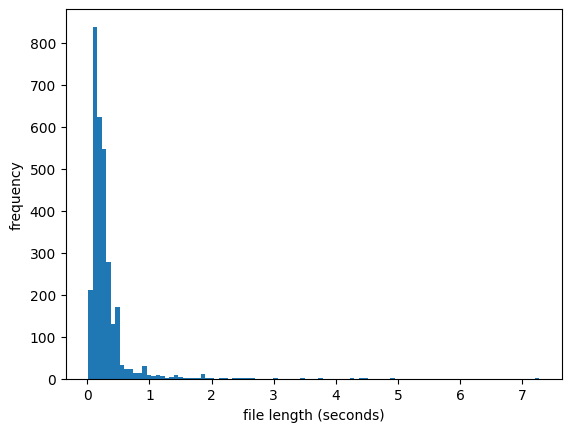

In [20]:
scaled_lengths = np.divide(lengths, 44100)

plt.hist(scaled_lengths, bins=100, log=False)
plt.xlabel("file length (seconds)")
plt.ylabel("frequency")
plt.show()

In [24]:
def pad_spectrogram(spectrogram, num_frames, n_fft):
    # pad or trim to reach desired number of frames, also cut freq bins to n_fft/2
    pad_amount = max(0, num_frames - np.shape(spectrogram)[1])
    pad_mat = ((0, 0), (0, pad_amount)) 
    spectrogram = np.pad(spectrogram, pad_mat, mode='constant', constant_values=-80)

    #cutoff_bin = np.shape(spectrogram)[0] - 1000
    cutoff_bin = n_fft//2
    spectrogram = spectrogram[:cutoff_bin, :num_frames]  
    return spectrogram

def scale_spectrogram(spectrogram):
    return np.divide(spectrogram, 80) + 1

def re_scale_spectrogram(spectrogram):
    return np.multiply(spectrogram - 1, 80)

def re_pad_spectrogram(spectrogram):
    pad_mat = ((0,1), (0,0))
    spectrogram = np.pad(spectrogram, pad_mat, mode='constant', constant_values=-80)
    return spectrogram

In [5]:
def generate_spectrogram(wav_file_path, n_fft, hop_length, plot=False):
    # Load the audio file
    y, sr = librosa.load(wav_file_path, sr=None)

    # Generate a spectrogram
    D = librosa.amplitude_to_db(np.abs(librosa.stft(y, n_fft=n_fft, win_length=n_fft, hop_length=hop_length)), ref=np.max)

    # Display the spectrogram
    if(plot):
        plt.figure(figsize=(8, 4))
        librosa.display.specshow(D, sr=sr, x_axis='time', y_axis='log')
        plt.colorbar(format='%+2.0f dB')
        plt.title('Spectrogram of {}'.format(os.path.basename(wav_file_path)))
        plt.show()
        print("dimension: ", np.shape(D)[0], " * ", np.shape(D)[1])

    return D, sr


def spectrogram_to_waveform(spectrogram, n_fft, hop_length):
    # Convert the spectrogram back to a waveform
    y_reconstructed = librosa.griffinlim(librosa.db_to_amplitude(spectrogram), n_fft=n_fft, win_length=n_fft, hop_length=hop_length)
    
    # scale to 0dB
    max_peak = np.max(np.abs(y_reconstructed))
    gain = 1 / max_peak 
    y_reconstructed = y_reconstructed * gain

    return y_reconstructed


def apply_fadeout(audio, sr, duration=0.1):
    # convert to audio indices (samples)
    length = int(duration*sr)
    end = audio.shape[0]
    start = end - length

    # compute fade out curve
    # linear fade
    fade_curve = np.linspace(1.0, 0.0, length)

    # apply the curve
    audio[start:end] = audio[start:end] * fade_curve

    return audio


def test_spectrograms():
    #n_fft = 64
    n_fft = 2048
    hop_length = n_fft // 2
    n_frames = 16

    source_file = wav_files[1000]

    print(source_file)
    print(os.path.basename(source_file))

    destination_path = os.path.join(base_dir, "data", "reconstructed_audio_files")

    for i in range(0, 20):
        spectrogram, sr = generate_spectrogram(wav_files[i], n_fft=n_fft, hop_length=hop_length, plot=False)
        spectrogram = pad_spectrogram(spectrogram, n_frames, n_fft)

        plt.figure(figsize=(8, 4))
        librosa.display.specshow(spectrogram, sr=sr, x_axis='time', y_axis='log')
        plt.colorbar(format='%+2.0f dB')
        #plt.title('Spectrogram of {}'.format(os.path.basename(wav_file_path)))
        plt.show()
        print("dimension: ", np.shape(spectrogram)[0], " * ", np.shape(spectrogram)[1])

        spectrogram = re_pad_spectrogram(spectrogram)
        reconstructed_waveform = spectrogram_to_waveform(spectrogram, n_fft, hop_length)
        reconstructed_waveform = apply_fadeout(reconstructed_waveform, sr)

        destination_file = os.path.join(destination_path, "reconstructed_" + os.path.basename(wav_files[i]))
        sf.write(destination_file, reconstructed_waveform, sr)

In [6]:
def preprocess_data(raw_data_path, processed_data_path, params):

    destination_subfolder_name = "nfft"+str(params["n_fft"])+"_hop"+str(params["hop_length"])+"_nframes"+str(params["n_frames"])
    destination_subfolder = os.path.join(processed_data_path, destination_subfolder_name)


    print("saving to ", destination_subfolder)
    
    if os.path.exists(destination_subfolder):
            print("config exists - overwriting...")
    else:
        os.mkdir(destination_subfolder)

    for folder_name in os.listdir(raw_data_path):
        print(folder_name)
        
        source_file_path = os.path.join(raw_data_path, folder_name)
        destination_file_path = os.path.join(destination_subfolder, folder_name)
        print(destination_file_path)

        if not os.path.exists(destination_file_path):
            os.mkdir(destination_file_path)

        for file_name in os.listdir(source_file_path):

            if not file_name.startswith('.') and file_name.endswith('.wav'):
                wav_path = os.path.join(source_file_path, file_name)
                npy_path = os.path.join(destination_file_path, os.path.splitext(file_name)[0])

                # generate spectrogram, pad and scale to range [0,1]
                spectrogram, _ = generate_spectrogram(wav_path, n_fft=params["n_fft"], hop_length=params["hop_length"])
                spectrogram = pad_spectrogram(spectrogram, num_frames=params["n_frames"], n_fft=params["n_fft"])
                spectrogram = scale_spectrogram(spectrogram)

                # save spectrogram
                np.save(npy_path, spectrogram)




In [12]:
raw_data_path = os.path.join(base_dir, 'data', 'training_raw')
processed_data_path = os.path.join(base_dir, 'data', 'training_processed')

params = {
"n_fft":2048,
"hop_length":1024,
"sample_rate":44100,
"n_frames": 16,
"sample_rate": 44100
}

#preprocess_data(raw_data_path, processed_data_path, params)


In [8]:
wav_file_path = wav_files[2352]
spectrogram, _ = generate_spectrogram(wav_file_path, n_fft=params["n_fft"], hop_length=params["hop_length"])

spectrogram = pad_spectrogram(spectrogram, 16)
spectrogram = scale_spectrogram(spectrogram)

plt.figure(figsize=(8, 4))
librosa.display.specshow(spectrogram, sr=sr, x_axis='time', y_axis='log')
plt.title('Spectrogram of {}'.format(os.path.basename(wav_file_path)))
plt.colorbar(format='%+2.1f')
plt.show()
print("dimension: ", np.shape(spectrogram)[0], " * ", np.shape(spectrogram)[1])

NameError: name 'wav_files' is not defined

In [36]:
testdir = "E:/Work/audio_generation/data/training_processed/nfft2048_hop1024_nframes16/VMH1 Bassdrums/VMH1 Bassdrums 001.npy"
spectest = np.load(testdir)
spectest.shape

(1024, 16)

In [40]:
def reconstruct_samples(source_directory, target_directory, params, display=False):
    count = 0
    for f in os.listdir(source_directory):
        count += 1
        #if count == 10:
        #    return 0
        if f.endswith('.npy'):
            source_file_path = os.path.join(source_directory, f)
            

            spectrogram = np.load(source_file_path)
            spectrogram = re_scale_spectrogram(spectrogram)
            spectrogram = re_pad_spectrogram(spectrogram)
            
            
            if(display):
                plt.figure(figsize=(8, 4))
                librosa.display.specshow(spectrogram, sr=params["sample_rate"], x_axis='time', y_axis='log')
                plt.colorbar(format='%+2.0f dB')
                plt.title('Spectrogram of {}'.format(os.path.basename(f)))
                plt.show()
                print("dimension: ", np.shape(spectrogram)[0], " * ", np.shape(spectrogram)[1])
                    
            reconstructed_waveform = spectrogram_to_waveform(spectrogram, params["n_fft"], params["hop_length"])
            reconstructed_waveform = apply_fadeout(reconstructed_waveform, params["sample_rate"])

            target_file_path = os.path.join(target_directory, "reconstructed_" + os.path.basename(f) + ".wav")
            sf.write(target_file_path, reconstructed_waveform, params["sample_rate"])


In [41]:
rec_source_directory = os.path.join(base_dir, 'data', 'sample_vae')
rec_target_directory = os.path.join(base_dir, 'data', 'sample_reconstructed')

reconstruct_samples(rec_source_directory, rec_target_directory, params)